
=== Arena ===
  Original sequences: 249
  Recoded sequences : 229

=== Calici ===
  Original sequences: 72
  Recoded sequences : 66

=== Corona ===
  Original sequences: 458
  Recoded sequences : 437

=== Filo ===
  Original sequences: 125
  Recoded sequences : 120

=== Flavi ===
  Original sequences: 60
  Recoded sequences : 46

=== Hanta ===
  Original sequences: 131
  Recoded sequences : 120

=== Picorna ===
  Original sequences: 648
  Recoded sequences : 448

=== Orthomyxo ===
  Original sequences: 67
  Recoded sequences : 66

=== Paramyxo ===
  Original sequences: 647
  Recoded sequences : 572

=== Peribunya ===
  Original sequences: 3
  Recoded sequences : 3

=== Rhabdo ===
  Original sequences: 193
  Recoded sequences : 187


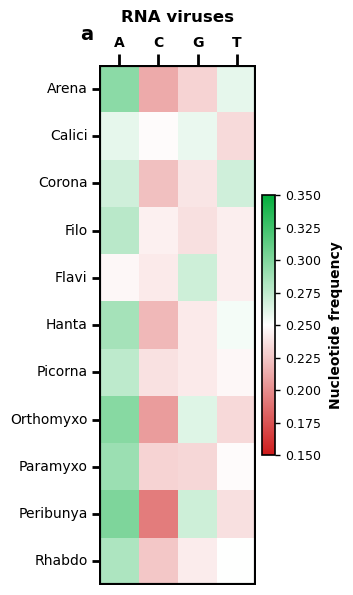

In [15]:
# --- Random recode + nucleotide-frequency heatmap (white=0.25, red<, blue>) ---

import os, random, math
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

# ======================= CONFIG (edit these) =======================
BASE_DIR = Path("/Users/ishaharris/Projects/ribolings")
CODON_TABLE_CSV = BASE_DIR / "data" / "CodonSwapTable.csv"

# Input FASTAs folder (expects one FASTA per family, e.g. 'Pox.fasta')
FASTA_DIR = BASE_DIR / "data" / "virus" / "rna_cds_fasta"

# Where to write recoded FASTAs (one per family). Set to None to skip saving.
OUTPUT_DIR = None

# Which families to process (same as your R lists). You can combine or subset.
DNA_VIRUS_LIST = ['Adeno','Anello','Asfar','Circo',
                  'Herpes','Irido','Papilloma','Parvo','Polyomar','Pox']
FULL_RNA_VIRUS_LIST = ['Arteri','Arena','Astro','Borna','Calici','Corona','Filo','Flavi',
                  'Hanta','Hepe','Picorna','Tobani','Orthomyxo','Paramyxo','Peribunya',
                  'Pneumo','Rhabdo','Spinareo','Kolmio','Noda','Birna','Sedereo']
RNA_VIRUS_LIST = ['Arena', 'Calici', 'Corona', 'Filo', 'Flavi', 'Hanta', 'Picorna', 'Orthomyxo', 'Paramyxo', 'Peribunya','Rhabdo']  
VIRUS_LIST = RNA_VIRUS_LIST   # <- change to RNA_VIRUS_LIST or DNA_VIRUS_LIST NA_VIRUS_LIST

RANDOM_SEED = 42
STRICT_FILTERS = True  # enforce: only A/C/G/T, frame 0, ATG start, single terminal stop
SAVE_RECODED_FASTA = False
# ================================================================

random.seed(RANDOM_SEED)

VALID_BASES = set("ACGT")
STOPS = {"TGA","TAA","TAG"}

# ---- Load codon-swap table (expects columns: Codon, Number, then alternatives in cols 4+) ----
swap_df = pd.read_csv(CODON_TABLE_CSV)
if "Codon" not in swap_df.columns or "Number" not in swap_df.columns:
    raise ValueError("CodonSwapTable.csv must contain 'Codon' and 'Number' columns.")

# Build dict: original codon (upper) -> list of alternative codons (upper)
alt_cols = list(swap_df.columns[3:])  # alternatives start at 4th column (0-based index 3)
swap_map = {}
for _, row in swap_df.iterrows():
    codon = str(row["Codon"]).upper()
    alts = [str(x).upper() for x in row[alt_cols].tolist() if pd.notna(x)]
    # Keep only valid DNA codons (A/C/G/T) of length 3
    alts = [a for a in alts if len(a)==3 and set(a).issubset(VALID_BASES)]
    swap_map[codon] = alts

# ---- Helpers ----
def is_valid_seq(seq: str) -> bool:
    return set(seq).issubset(VALID_BASES) and len(seq) % 3 == 0

def split_codons(seq: str):
    return [seq[i:i+3] for i in range(0, len(seq), 3)]

def count_stops(codons):
    return sum(1 for c in codons if c in STOPS)

def recode_cds(seq: str) -> str | None:
    """Return recoded sequence (same aa length) or None if it fails filters when STRICT_FILTERS=True."""
    seq = seq.upper().replace("U","T")
    if not is_valid_seq(seq):
        return None if STRICT_FILTERS else seq
    codons = split_codons(seq)
    if len(codons) < 2:
        return None if STRICT_FILTERS else seq
    # Filters like the R script
    if STRICT_FILTERS:
        if codons[0] != "ATG": return None
        if codons[-1] not in STOPS: return None
        if count_stops(codons) != 1: return None  # only terminal stop
    # Recode every codon except the last (keep stop)
    recoded = []
    for c in codons[:-1]:
        alts = swap_map.get(c)
        if not alts:
            # If no alternatives found, keep original codon
            recoded.append(c)
        else:
            recoded.append(random.choice(alts))
    recoded.append(codons[-1])  # keep stop
    return "".join(recoded)

def pooled_nt_freq(seqs: list[str]) -> dict:
    """Pooled nucleotide frequencies across sequences."""
    total = Counter()
    for s in seqs:
        total.update(s)
    n = sum(total[b] for b in "ACGT")
    if n == 0:
        return {b: float("nan") for b in "ACGT"}
    return {b: total[b]/n for b in "ACGT"}

# ---- Process families ----
records_summary = []
freq_rows = []

if OUTPUT_DIR and SAVE_RECODED_FASTA:
    OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

for family in VIRUS_LIST:
    in_path = Path(FASTA_DIR) / f"{family}.fasta"
    if not in_path.exists():
        print(f"[SKIP] {family}: FASTA not found -> {in_path}")
        continue

    print(f"\n=== {family} ===")
    orig_seqs = []
    recoded_seqs = []
    recoded_records = []

    n_in, n_ok = 0, 0
    for rec in SeqIO.parse(str(in_path), "fasta"):
        n_in += 1
        s = str(rec.seq).upper().replace("U","T")
        r = recode_cds(s)
        if r is None:
            continue
        n_ok += 1
        orig_seqs.append(s)
        recoded_seqs.append(r)
        recoded_records.append(rec.__class__(id=rec.id, name=rec.name, description=rec.description, seq=rec.seq.__class__(r)))

    print(f"  Original sequences: {n_in}")
    print(f"  Recoded sequences : {n_ok}")

    records_summary.append({"VirusFamily": family, "original": n_in, "recoded": n_ok})

    # Save recoded FASTA per family (optional)
    if SAVE_RECODED_FASTA and recoded_records:
        out_path = Path(OUTPUT_DIR) / f"{family}_recoded.fasta"
        SeqIO.write(recoded_records, str(out_path), "fasta")
        print(f"  Wrote: {out_path}")

    # Pooled nucleotide frequencies for RECoded (heatmap target)
    if recoded_seqs:
        freq = pooled_nt_freq(recoded_seqs)
        freq_rows.append({"VirusFamily": family, **freq})

# ---- Build DataFrame for heatmap ----
freq_df = pd.DataFrame(freq_rows).set_index("VirusFamily").reindex(VIRUS_LIST)
freq_df = freq_df[["A","C","G","T"]]  # consistent column order

# --- Pretty heatmap: tall/narrow, thick border, ticks on top, no colorbar ---

# --- Landscape-style heatmap: wide cells, bold outer border, drop-in legend ---

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap

# Muted purple → white → blue palette
cmap_ref = LinearSegmentedColormap.from_list(
    "muted_purple_blue",
    ["#ce1b1b", "#ffffff", "#03ae3c"]
)

# Clamp and center
norm = TwoSlopeNorm(vmin=0.15, vcenter=0.25, vmax=0.35)

# Adjust figsize: wide boxes (width > height)
plt.figure(figsize=(3.5, 2.2 + 0.35 * len(freq_df)))  # height scales with rows

ax = sns.heatmap(
    freq_df,
    cmap=cmap_ref,
    norm=norm,
    cbar=True,
    cbar_kws={"shrink": 0.5, "pad": 0.03},
    linewidths=0,                 # no inner gridlines
    xticklabels=True,
    yticklabels=True,
    square=False                  # allows rectangular (wide) cells

    
)



# Labels & ticks
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels(["A", "C", "G", "T"], rotation=0, ha="center", fontweight="bold")
ax.xaxis.set_ticks_position("top")
ax.tick_params(axis="x", top=True, bottom=False, length=8, width=2, direction="out", pad=3)
ax.tick_params(axis="y", left=True, right=False, length=5, width=2, direction="out")

# Title & panel label
ax.set_title("RNA viruses", fontweight="bold", pad=10)
ax.text(-0.12, 1.04, "a", transform=ax.transAxes, va="bottom",
        ha="left", fontsize=14, fontweight="bold")

# Get axis limits for the drawn heatmap (cells start at 0, end at ncols/nrows)
import matplotlib.patches as patches
nrows, ncols = freq_df.shape
rect = patches.Rectangle(
    (0, 0),                      # bottom left corner
    ncols, nrows,                # width = #columns, height = #rows
    fill=False,
    edgecolor="black",
    linewidth=3.0
)
ax.add_patch(rect)

# Legend styling
cbar = ax.collections[0].colorbar
cbar.set_label("Nucleotide frequency", fontsize=10, fontweight="bold", labelpad=6)
cbar.ax.tick_params(labelsize=9, width=1)
cbar.outline.set_linewidth(1.2)

plt.tight_layout()
plt.show()


# Freq A Bar Chart
- Must be run after previous cell

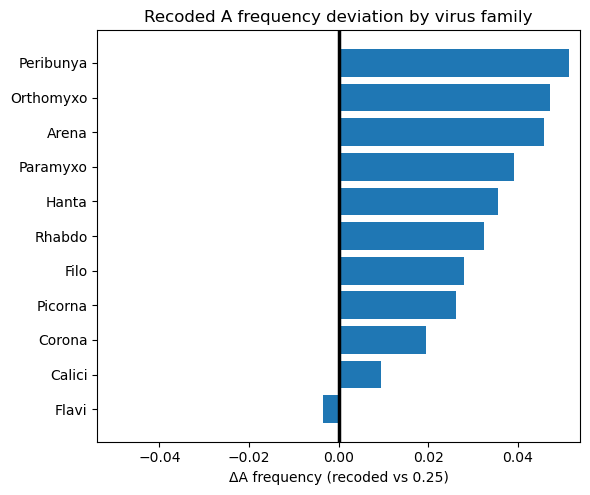

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Take A frequency and centre it at 0.25 so the baseline is 0
a = (freq_df["A"] - 0.25).dropna()
a = a.sort_values()  # order by deviation

# Figure size scales with number of families
h = 0.35 * len(a) + 1.2
plt.figure(figsize=(6.0, h))

# Bars
ypos = np.arange(len(a))
plt.barh(ypos, a.values)

# Y labels = families
plt.yticks(ypos, a.index)

# Zero line + axes styling
plt.axvline(0, linewidth=2.5, color="black")
plt.xlabel("ΔA frequency (recoded vs 0.25)")
plt.ylabel("")
plt.title("Recoded A frequency deviation by virus family")

# Symmetric x-limits around 0
m = np.nanmax(np.abs(a.values))
plt.xlim(-m*1.05, m*1.05)

plt.tight_layout()
plt.show()


# WT vs recoded A-freq difference bar chart


=== Arena ===
  Original sequences: 249
  Recoded sequences : 229

=== Calici ===
  Original sequences: 72
  Recoded sequences : 66

=== Corona ===
  Original sequences: 458
  Recoded sequences : 437

=== Filo ===
  Original sequences: 125
  Recoded sequences : 120

=== Flavi ===
  Original sequences: 60
  Recoded sequences : 46

=== Hanta ===
  Original sequences: 131
  Recoded sequences : 120

=== Picorna ===
  Original sequences: 648
  Recoded sequences : 448

=== Orthomyxo ===
  Original sequences: 67
  Recoded sequences : 66

=== Paramyxo ===
  Original sequences: 647
  Recoded sequences : 572

=== Peribunya ===
  Original sequences: 3
  Recoded sequences : 3

=== Rhabdo ===
  Original sequences: 193
  Recoded sequences : 187


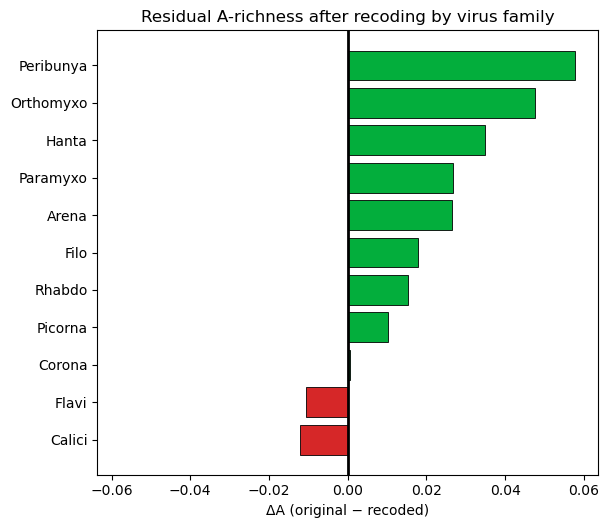


ΔA (original − recoded) by family:


,ΔA
VirusFamily,
Calici,-0.012053
Flavi,-0.010632
Corona,0.000485
Picorna,0.010290
Rhabdo,0.015374
Filo,0.017933
Arena,0.026466
Paramyxo,0.026816
Hanta,0.034747


In [20]:
# === Recoding impact on A: ΔA = A_original − A_recoded, by virus family ===
import os, random
from pathlib import Path
from collections import Counter
from typing import List, Dict

import numpy as np
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt

# ======================= CONFIG =======================
BASE_DIR = Path("/Users/ishaharris/Projects/ribolings")
CODON_TABLE_CSV = BASE_DIR / "data" / "CodonSwapTable.csv"
FASTA_DIR = BASE_DIR / "data" / "virus" / "rna_cds_fasta"

RNA_VIRUS_LIST = [
    'Arena','Calici','Corona','Filo','Flavi',
    'Hanta','Picorna','Orthomyxo','Paramyxo','Peribunya','Rhabdo'
]
VIRUS_LIST = RNA_VIRUS_LIST   # or DNA_VIRUS_LIST if desired

RANDOM_SEED = 42
STRICT_FILTERS = True  # enforce valid bases, frame 0, ATG start, single stop
# ======================================================

random.seed(RANDOM_SEED)
VALID_BASES = set("ACGT")
STOPS = {"TGA","TAA","TAG"}

# ---- Load codon swap table ----
swap_df = pd.read_csv(CODON_TABLE_CSV)
if "Codon" not in swap_df.columns or "Number" not in swap_df.columns:
    raise ValueError("CodonSwapTable.csv must contain 'Codon' and 'Number' columns.")
alt_cols = list(swap_df.columns[3:])
swap_map: Dict[str, List[str]] = {}
for _, row in swap_df.iterrows():
    codon = str(row["Codon"]).upper()
    alts = [str(x).upper() for x in row[alt_cols].tolist() if pd.notna(x)]
    alts = [a for a in alts if len(a) == 3 and set(a).issubset(VALID_BASES)]
    swap_map[codon] = alts

# ---- Helpers ----
def is_valid_seq(seq: str) -> bool:
    return set(seq).issubset(VALID_BASES) and len(seq) % 3 == 0

def split_codons(seq: str): return [seq[i:i+3] for i in range(0, len(seq), 3)]
def count_stops(codons): return sum(1 for c in codons if c in STOPS)

def recode_cds(seq: str) -> str | None:
    seq = seq.upper().replace("U","T")
    if not is_valid_seq(seq):
        return None if STRICT_FILTERS else seq
    codons = split_codons(seq)
    if len(codons) < 2:
        return None if STRICT_FILTERS else seq
    if STRICT_FILTERS:
        if codons[0] != "ATG": return None
        if codons[-1] not in STOPS: return None
        if count_stops(codons) != 1: return None
    recoded = []
    for c in codons[:-1]:
        alts = swap_map.get(c)
        recoded.append(random.choice(alts) if alts else c)
    recoded.append(codons[-1])
    return "".join(recoded)

def pooled_nt_freq(seqs: List[str]) -> Dict[str, float]:
    total = Counter()
    for s in seqs: total.update(s)
    n = sum(total[b] for b in "ACGT")
    return {b: total[b]/n if n > 0 else np.nan for b in "ACGT"}

# ---- Process each family ----
rows = []
for family in VIRUS_LIST:
    in_path = Path(FASTA_DIR) / f"{family}.fasta"
    if not in_path.exists():
        print(f"[SKIP] {family}: missing FASTA -> {in_path}")
        continue

    print(f"\n=== {family} ===")
    orig_seqs, recoded_seqs = [], []
    n_in = n_ok = 0

    for rec in SeqIO.parse(str(in_path), "fasta"):
        n_in += 1
        s = str(rec.seq).upper().replace("U","T")
        r = recode_cds(s)
        if r is None: continue
        n_ok += 1
        orig_seqs.append(s)
        recoded_seqs.append(r)

    print(f"  Original sequences: {n_in}")
    print(f"  Recoded sequences : {n_ok}")

    if recoded_seqs:
        f_ori = pooled_nt_freq(orig_seqs)
        f_rec = pooled_nt_freq(recoded_seqs)
        rows.append({
            "VirusFamily": family,
            "A_original": f_ori["A"],
            "A_recoded":  f_rec["A"],
        })

# ---- Combine + compute ΔA = original − recoded ----
df = pd.DataFrame(rows).set_index("VirusFamily").reindex(VIRUS_LIST)
df["ΔA"] = df["A_original"] - df["A_recoded"]

# ---- Plot ----
a_diff = df["ΔA"].dropna().sort_values()
plt.figure(figsize=(6.2, 0.38 * len(a_diff) + 1.2))
ypos = np.arange(len(a_diff))
colors = np.where(a_diff.values >= 0, "#03ae3c", "tab:red")
plt.barh(ypos, a_diff.values, color=colors, edgecolor="black", linewidth=0.6)

plt.yticks(ypos, a_diff.index)
plt.axvline(0, color="black", linewidth=2)
plt.xlabel("ΔA (original − recoded)")
plt.title("Residual A-richness after recoding by virus family")

m = float(np.nanmax(np.abs(a_diff.values))) if len(a_diff) else 0.01
plt.xlim(-m * 1.1, m * 1.1)
plt.tight_layout()
plt.show()

print("\nΔA (original − recoded) by family:")
display(a_diff.to_frame("ΔA"))


# CSV save

In [1]:
# ======================= Standalone: Nucleotide frequencies CSV =======================
import random
from pathlib import Path
from collections import Counter
import pandas as pd
from Bio import SeqIO

# ----------------------------- CONFIG -----------------------------
BASE_DIR = Path("/Users/ishaharris/Projects/ribolings")
FASTA_DIR = BASE_DIR / "data" / "virus" / "rna_cds_fasta"
CODON_TABLE_CSV = BASE_DIR / "data" / "CodonSwapTable.csv"
RANDOM_SEED = 42
VIRUS_LIST = ['Arena', 'Calici', 'Corona', 'Filo', 'Flavi', 'Hanta', 
              'Picorna', 'Orthomyxo', 'Paramyxo', 'Peribunya','Rhabdo']
STRICT_FILTERS = True
VALID_BASES = set("ACGT")
STOPS = {"TGA","TAA","TAG"}

# ----------------------------- SETUP -----------------------------
random.seed(RANDOM_SEED)

# Load codon-swap table
swap_df = pd.read_csv(CODON_TABLE_CSV)
alt_cols = list(swap_df.columns[3:])
swap_map = {}
for _, row in swap_df.iterrows():
    codon = str(row["Codon"]).upper()
    alts = [str(x).upper() for x in row[alt_cols].tolist() if pd.notna(x)]
    alts = [a for a in alts if len(a)==3 and set(a).issubset(VALID_BASES)]
    swap_map[codon] = alts

# ----------------------------- HELPERS -----------------------------
def is_valid_seq(seq: str) -> bool:
    return set(seq).issubset(VALID_BASES) and len(seq) % 3 == 0

def split_codons(seq: str):
    return [seq[i:i+3] for i in range(0, len(seq), 3)]

def count_stops(codons):
    return sum(1 for c in codons if c in STOPS)

def recode_cds(seq: str) -> str | None:
    seq = seq.upper().replace("U","T")
    if not is_valid_seq(seq):
        return None if STRICT_FILTERS else seq
    codons = split_codons(seq)
    if len(codons) < 2:
        return None if STRICT_FILTERS else seq
    if STRICT_FILTERS:
        if codons[0] != "ATG": return None
        if codons[-1] not in STOPS: return None
        if count_stops(codons) != 1: return None
    recoded = [random.choice(swap_map.get(c, [c])) for c in codons[:-1]]
    recoded.append(codons[-1])
    return "".join(recoded)

def pooled_nt_freq(seqs: list[str]) -> dict:
    total = Counter()
    for s in seqs:
        total.update(s)
    n = sum(total[b] for b in "ACGT")
    if n == 0:
        return {b: float("nan") for b in "ACGT"}
    return {b: total[b]/n for b in "ACGT"}

# ----------------------------- PROCESS -----------------------------
orig_freq_rows = []
recoded_freq_rows = []

for family in VIRUS_LIST:
    in_path = Path(FASTA_DIR) / f"{family}.fasta"
    if not in_path.exists():
        print(f"[SKIP] {family}: FASTA not found -> {in_path}")
        continue

    print(f"Processing {family}...")
    orig_seqs = []
    recoded_seqs = []

    for rec in SeqIO.parse(str(in_path), "fasta"):
        s = str(rec.seq).upper().replace("U","T")
        r = recode_cds(s)
        if r is None:
            continue
        orig_seqs.append(s)
        recoded_seqs.append(r)

    if orig_seqs:
        orig_freq_rows.append({"VirusFamily": family, **pooled_nt_freq(orig_seqs)})
    if recoded_seqs:
        recoded_freq_rows.append({"VirusFamily": family, **pooled_nt_freq(recoded_seqs)})

# ----------------------------- SAVE CSVs -----------------------------
orig_freq_df = pd.DataFrame(orig_freq_rows).set_index("VirusFamily").reindex(VIRUS_LIST)[["A","C","G","T"]]
recoded_freq_df = pd.DataFrame(recoded_freq_rows).set_index("VirusFamily").reindex(VIRUS_LIST)[["A","C","G","T"]]

orig_csv_path = BASE_DIR / "virus_nt_freq_before_recode.csv"
recoded_csv_path = BASE_DIR / "virus_nt_freq_after_recode.csv"

orig_freq_df.to_csv(orig_csv_path)
recoded_freq_df.to_csv(recoded_csv_path)

print(f"Saved original frequencies -> {orig_csv_path}")
print(f"Saved recoded frequencies -> {recoded_csv_path}")


Processing Arena...
Processing Calici...
Processing Corona...
Processing Filo...
Processing Flavi...
Processing Hanta...
Processing Picorna...
Processing Orthomyxo...
Processing Paramyxo...
Processing Peribunya...
Processing Rhabdo...
Saved original frequencies -> /Users/ishaharris/Projects/ribolings/virus_nt_freq_before_recode.csv
Saved recoded frequencies -> /Users/ishaharris/Projects/ribolings/virus_nt_freq_after_recode.csv
